In [ ]:
import sys

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pytorch_grad_cam import (
    AblationCAM,
    EigenCAM,
    FullGrad,
    GradCAM,
    GradCAMPlusPlus,
    HiResCAM,
    ScoreCAM,
    XGradCAM,
)
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torch.utils.data import DataLoader
from torchvision import models
from PIL import Image

sys.path.append("../")
from src.dataset import get_val_dataset


In [175]:
batch_size = 4
val_ds = get_val_dataset()
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
)
x, y = next(iter(val_loader))
y

tensor([19, 20, 12, 28])

In [184]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 29)

state_dict = torch.load(
    "../frontend/best_model_params(3).pt", map_location=torch.device("cpu")
)
model.load_state_dict(state_dict)
_ = model.eval()

In [ ]:
CLASS_NAMES = [
            "Apple___Apple_scab",
            "Apple___Black_rot",
            "Apple___Cedar_apple_rust",
            "Apple___healthy",
            "Cherry_(including_sour)___Powdery_mildew",
            "Cherry_(including_sour)___healthy",
            "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
            "Corn_(maize)___Common_rust_",
            "Corn_(maize)___Northern_Leaf_Blight",
            "Corn_(maize)___healthy",
            "Grape___Black_rot",
            "Grape___Esca_(Black_Measles)",
            "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
            "Grape___healthy",
            "Pepper,_bell___Bacterial_spot",
            "Pepper,_bell___healthy",
            "Potato___Early_blight",
            "Potato___Late_blight",
            "Potato___healthy",
            "Tomato___Bacterial_spot",
            "Tomato___Early_blight",
            "Tomato___Late_blight",
            "Tomato___Leaf_Mold",
            "Tomato___Septoria_leaf_spot",
            "Tomato___Spider_mites Two-spotted_spider_mite",
            "Tomato___Target_Spot",
            "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
            "Tomato___Tomato_mosaic_virus",
            "Tomato___healthy",
        ]

In [186]:
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

In [187]:
image = Image.open("/home/jayh/Pictures/Plant/tom_bac_spot.jpg").convert("RGB")
# x = DATA_TRANSFORMS['val'](image)#.unsqueeze(0)

In [188]:
grayscale_cam = cam(input_tensor=x, targets=None)
pred_tensor = model(x)
pred_tensor.shape
soft = torch.nn.functional.softmax(pred_tensor, dim=1)
conf, pred_idx = torch.max(soft, dim=1)

In [189]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [190]:
masked = []
original = []
for i in range(len(grayscale_cam)):
    mask = grayscale_cam[i]

    img = x[i].permute(1, 2, 0).numpy()
    img = (img * std) + mean
    img = np.clip(img, 0, 1)

    masked.append(show_cam_on_image(img, mask, use_rgb=True))
    original.append(img)

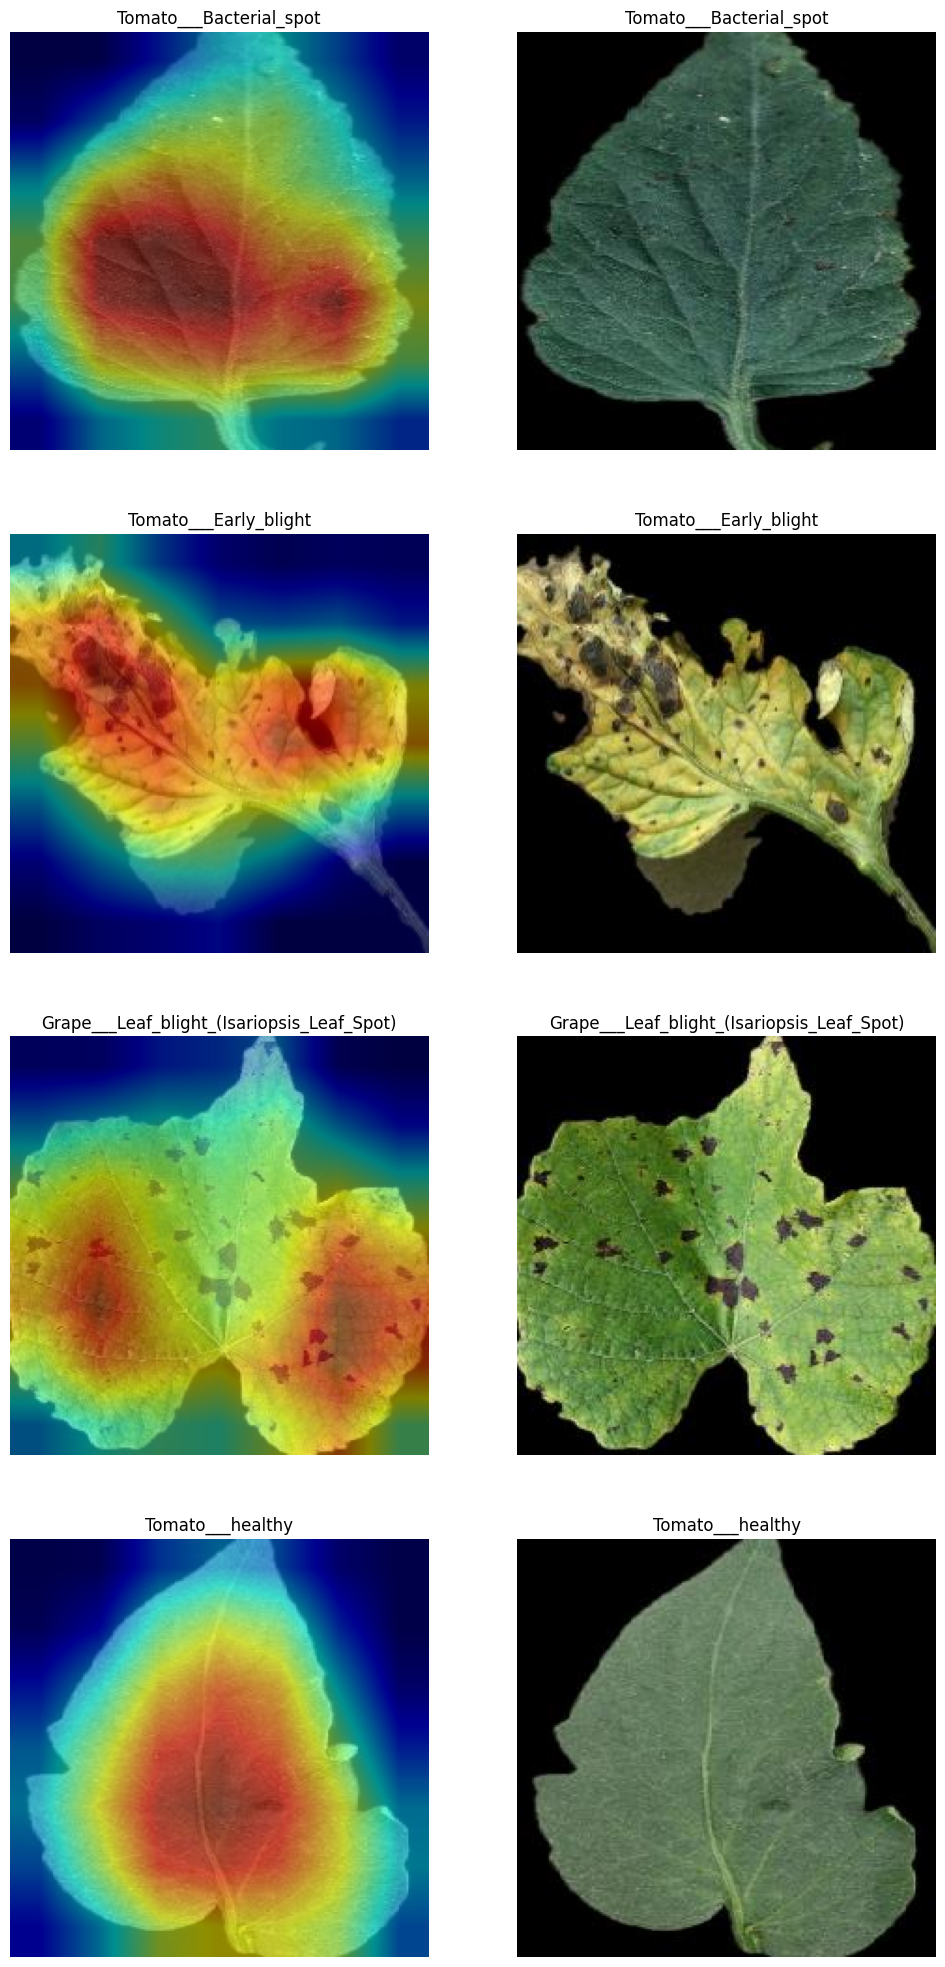

In [191]:
f, ax = plt.subplots(batch_size, 2, figsize=(12, 25))
for i, (m, o) in enumerate(zip(masked, original)):
    ax[i][0].set_title(CLASS_NAMES[pred_idx[i]])
    ax[i][0].set_axis_off()
    ax[i][1].set_title(CLASS_NAMES[y[i]])
    ax[i][1].set_axis_off()
    ax[i][0].imshow(m)
    ax[i][1].imshow(o)